In [25]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import spearmanr
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

import sys
sys.path.append("..")
from src.utils import add_zero
from src.utils import fix_colnames

In [2]:
data = pd.read_csv("../data/PRSA_data_2010.1.1-2014.12.31.csv")

In [3]:
data.columns = fix_colnames(data.columns)

In [4]:
print(data.shape)
data.head()

(43824, 13)


,no,year,month,day,hour,pm2_5,dewp,temp,pres,cbwd,iws,is,ir
0,1,2010,1,1,0,NaN,-21,-11.0,1021.0,NW,1.79,0,0
1,2,2010,1,1,1,NaN,-21,-12.0,1020.0,NW,4.92,0,0
2,3,2010,1,1,2,NaN,-21,-11.0,1019.0,NW,6.71,0,0
3,4,2010,1,1,3,NaN,-21,-14.0,1019.0,NW,9.84,0,0
4,5,2010,1,1,4,NaN,-20,-12.0,1018.0,NW,12.97,0,0


In [5]:
# Build date column: format Y-m-d H:m
data["month"] = data["month"].apply(add_zero)
data["day"]   = data["day"].apply(add_zero)
data["hour"]  = data["hour"].apply(add_zero)

date_str = (
    data["year"].astype(str) + "-" + 
    data["month"] + "-" + 
    data["day"] + " " + 
    data["hour"] + ":00"
)

data["date"] = pd.to_datetime(date_str)

In [8]:
# Remove missing values
data = data.dropna(subset=["pm2_5"])

In [15]:
# cbwd has these categories: SE, NW, NE and cv
# we can suppose that cv is SW
data["cbwd"] = data["cbwd"].replace({"cv": "SW"})

In [18]:
# drop some columns
cols_drop = ["no", "year", "day"]
data = data.drop(columns=cols_drop)

In [19]:
print(data.shape)
data.head()

(41757, 11)


,month,hour,pm2_5,dewp,temp,pres,cbwd,iws,is,ir,date
24,01,00,129.0,-16,-4.0,1020.0,SE,1.79,0,0,2010-01-02 00:00:00
25,01,01,148.0,-15,-4.0,1020.0,SE,2.68,0,0,2010-01-02 01:00:00
26,01,02,159.0,-11,-5.0,1021.0,SE,3.57,0,0,2010-01-02 02:00:00
27,01,03,181.0,-7,-5.0,1022.0,SE,5.36,1,0,2010-01-02 03:00:00
28,01,04,138.0,-7,-5.0,1022.0,SE,6.25,2,0,2010-01-02 04:00:00


### Visualization of the serie

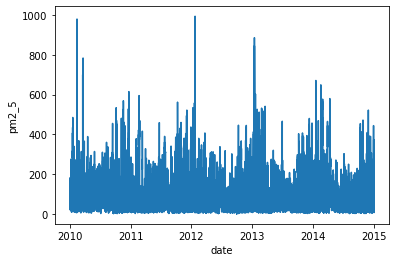

In [39]:
ax = sns.lineplot(x="date", y=target_str, data=data)
plt.show()

### Autocorrelation

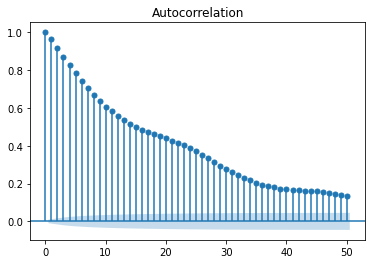

In [42]:
plot_acf(x=data[target_str], lags=50)
plt.show()

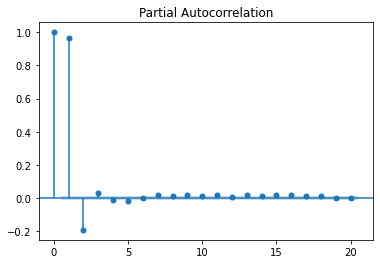

In [45]:
plot_pacf(x=data[target_str], lags=20)
plt.show()

This behaviour seem like an AR(2) model. We can use the last two lags as features for the regression approach.

### Cross-correlation

In [47]:
target_str = "pm2_5"
features = ["dewp", "temp", "pres", "iws"]

In [52]:
from scipy.signal import correlate

In [53]:
var = features[0]

In [68]:
def ccf(x, y, lag_max = 50):

    result = correlate(y - np.mean(y), x - np.mean(x), method='direct') / (np.std(y) * np.std(x) * len(y))
    length = (len(result) - 1) // 2
    lo = length - lag_max
    hi = length + (lag_max + 1)

    return result[lo:hi]

In [76]:
corr_result = ccf(x=data[var], y=data[target_str])

In [84]:
np.corrcoef(x=data[var].shift(-40).values, y=data[target_str].values)

array([[nan, nan],
       [nan,  1.]])

<AxesSubplot:>

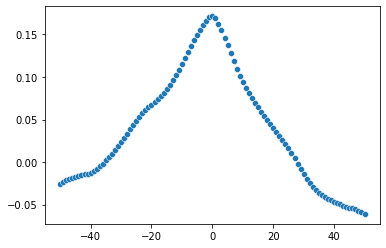

In [77]:
sns.scatterplot(x=range(-50, 51), y=corr_result)

### Correlation

We are going to compute spearman coefficient, because it is a non-parametric statistic based on rank.

**************************************** dewp
rho = 0.2997061253827784
p-value = 0.0


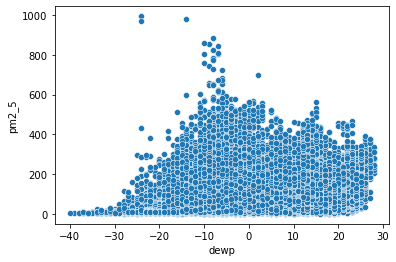

**************************************** temp
rho = 0.010783648336008554
p-value = 0.027553479079195028


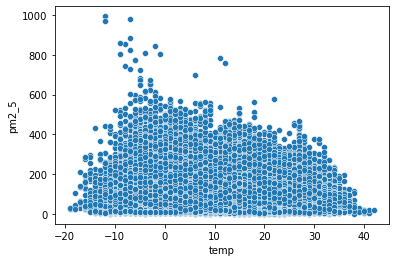

**************************************** pres
rho = -0.14166775859702926
p-value = 4.1382251518350816e-186


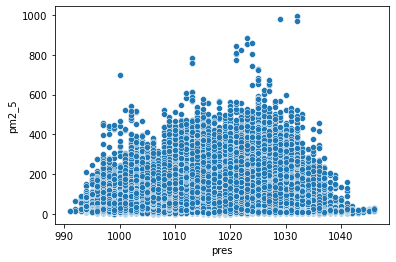

**************************************** iws
rho = -0.3600187681229539
p-value = 0.0


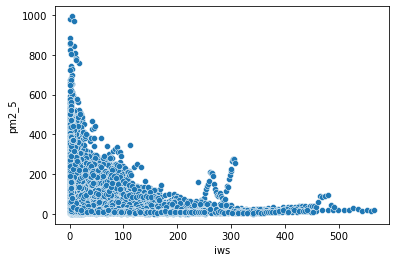

In [33]:
for var in features:
    print("*"*40, var)
    corr_result = spearmanr(data[var], data[target_str])

    print("rho =", corr_result.correlation)
    print("p-value =", corr_result.pvalue)

    ax = sns.scatterplot(x=var, y=target_str, data=data)
    plt.show()